In [23]:
import pandas as pd
from darts import TimeSeries
from darts.models import TCNModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [24]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [25]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [26]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = TCNModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=29,
        output_chunk_length=1,
        num_filters=50,
        kernel_size=8,
        num_layers=3,
        dilation_base=4,
        weight_norm=True,
        n_epochs=100,
        batch_size=107,
        dropout=0.10987578257441336,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.AdamW,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.004525867812805064, "weight_decay": 0.00015619537785532893}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.034
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.028
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.025
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.024
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.019
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.017
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.017. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    13.572883    3.684139    2.808369  0.728917   
Precipitation_accumulated       0.211855    0.460277    0.413706  0.663905   
Humidity                      158.528978   12.590829    9.115995  0.495175   
Wind_Speed_kmh                  0.574041    0.757655    0.598736 -0.358189   
Soil_Moisture              213745.875937  462.326590  393.433213  0.655529   
Soil_Temperature                8.910666    2.985074    2.116032  0.877543   
Wind_Dir_Sin                    0.265956    0.515710    0.419134  0.167788   
Wind_Dir_Cos                    0.333862    0.577808    0.430831  0.136920   

                                SMAPE  
Temperature                 15.809403  
Precipitation_accumulated   13.069086  
Humidity                    19.862931  
Wind_Speed_kmh              65.077577  
Soil_Mo

Metric val_loss improved. New best score: 9.349
Metric val_loss improved by 0.668 >= min_delta = 0.001. New best score: 8.681
Metric val_loss improved by 0.409 >= min_delta = 0.001. New best score: 8.272
Metric val_loss improved by 0.291 >= min_delta = 0.001. New best score: 7.982
Metric val_loss improved by 0.372 >= min_delta = 0.001. New best score: 7.610
Metric val_loss improved by 0.379 >= min_delta = 0.001. New best score: 7.232
Metric val_loss improved by 0.370 >= min_delta = 0.001. New best score: 6.862
Metric val_loss improved by 0.347 >= min_delta = 0.001. New best score: 6.515
Metric val_loss improved by 0.272 >= min_delta = 0.001. New best score: 6.243
Metric val_loss improved by 0.195 >= min_delta = 0.001. New best score: 6.047
Metric val_loss improved by 0.184 >= min_delta = 0.001. New best score: 5.864
Metric val_loss improved by 0.211 >= min_delta = 0.001. New best score: 5.653
Metric val_loss improved by 0.234 >= min_delta = 0.001. New best score: 5.419
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                5.099765e+04   225.826584   192.833068   
Precipitation_accumulated  1.089485e+03    33.007352    27.162566   
Humidity                   1.214845e+05   348.546259   294.455584   
Wind_Speed_kmh             9.215196e+01     9.599581     8.259486   
Soil_Moisture              2.177393e+07  4666.254620  3626.586890   
Soil_Temperature           2.542088e+04   159.439274   134.604555   
Wind_Dir_Sin               1.984567e+03    44.548476    37.881083   
Wind_Dir_Cos               1.268363e+02    11.262163     9.640343   

                                    R2       SMAPE  
Temperature               -1469.100166  153.506785  
Precipitation_accumulated     0.972490    8.014667  
Humidity                   -967.363666  143.987463  
Wind_Speed_kmh             -280.230467  152.955320  
Soil_Moisture          

Metric val_loss improved. New best score: 0.021
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.011
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.007
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many wor

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE            R2  \
Temperature                   6.212345   2.492458   2.090430 -1.168409e-01   
Precipitation_accumulated   288.049760  16.972029  14.495465 -2.446864e+06   
Humidity                     13.003901   3.606092   2.954980  2.449206e-01   
Wind_Speed_kmh                0.017753   0.133242   0.107224          -inf   
Soil_Moisture              2947.754957  54.293231  43.264529 -1.202858e+00   
Soil_Temperature              2.746871   1.657369   1.259413  5.649460e-01   
Wind_Dir_Sin                  0.003682   0.060682   0.052644          -inf   
Wind_Dir_Cos                  0.004335   0.065844   0.055857          -inf   

                                SMAPE  
Temperature                 13.996742  
Precipitation_accumulated    3.097089  
Humidity                     3.322401  
Wind_Speed_kmh             200.000000  
Soil_Mo

Metric val_loss improved. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/py

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    0.426940    0.653406    0.431116     0.242693   
Precipitation_accumulated     73.788580    8.590028    6.980452 -2232.057320   
Humidity                      18.063612    4.250131    2.249013    -0.851235   
Wind_Speed_kmh                 0.014767    0.121519    0.080286         -inf   
Soil_Moisture              94501.215635  307.410500  142.901407    -1.735968   
Soil_Temperature               0.964816    0.982250    0.661410    -3.264865   
Wind_Dir_Sin                   0.003287    0.057332    0.046040         -inf   
Wind_Dir_Cos                   0.001421    0.037702    0.027343         -inf   

                                SMAPE  
Temperature                  4.498264  
Precipitation_accumulated    1.540522  
Humidity                     2.392032  
Wind_Speed_kmh             20

Metric val_loss improved. New best score: 0.004
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.002
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   0.689521   0.830374   0.637053    0.709674   
Precipitation_accumulated    29.820171   5.460785   4.289842 -103.861843   
Humidity                     13.624095   3.691083   3.115574    0.707845   
Wind_Speed_kmh                0.013470   0.116059   0.082791   -5.477236   
Soil_Moisture              2284.649402  47.798006  35.165577    0.716057   
Soil_Temperature              0.560229   0.748484   0.609425    0.654284   
Wind_Dir_Sin                  0.016878   0.129915   0.074446    0.708198   
Wind_Dir_Cos                  0.028224   0.167999   0.108478    0.680766   

                                SMAPE  
Temperature                  9.144714  
Precipitation_accumulated    0.941258  
Humidity                     3.764445  
Wind_Speed_kmh             190.200919  
Soil_Moisture            

Metric val_loss improved. New best score: 0.026
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                    1.286411    1.134200    0.811061    0.862968   
Precipitation_accumulated    231.685199   15.221209   13.223032 -199.123902   
Humidity                      10.497486    3.239982    2.407505    0.908977   
Wind_Speed_kmh                 0.587847    0.766712    0.514442    0.622150   
Soil_Moisture              51611.117546  227.180804  178.623367    0.959618   
Soil_Temperature               2.366593    1.538374    1.215292    0.529822   
Wind_Dir_Sin                   0.401375    0.633542    0.452689    0.159782   
Wind_Dir_Cos                   0.309050    0.555923    0.417914    0.366675   

                                SMAPE  
Temperature                 27.180222  
Precipitation_accumulated    2.917833  
Humidity                     2.675106  
Wind_Speed_kmh              85.677956 

Metric val_loss improved. New best score: 0.016
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   2.043570   1.429535   1.153918    0.924472   
Precipitation_accumulated    55.725740   7.464968   5.965663 -189.674868   
Humidity                     10.676118   3.267433   2.429184    0.929335   
Wind_Speed_kmh                0.487001   0.697855   0.521995    0.594738   
Soil_Moisture              6600.517141  81.243567  67.176774   -0.116076   
Soil_Temperature              0.939300   0.969175   0.808427    0.915760   
Wind_Dir_Sin                  0.385553   0.620929   0.509090    0.280863   
Wind_Dir_Cos                  0.306116   0.553278   0.451349    0.099355   

                                SMAPE  
Temperature                 12.785498  
Precipitation_accumulated    1.292884  
Humidity                     2.976218  
Wind_Speed_kmh              52.416301  
Soil_Moisture            

In [27]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TCNModel(output_chunk_shift=0, kernel_size=8, num_filters=50, num_layers=3, dilation_base=4, weight_norm=True, dropout=0.10987578257441336, model_name=model_1, input_chunk_length=29, output_chunk_length=1, n_epochs=100, batch_size=107, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fa0e93b9df0>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adamw.AdamW'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 5, 'min_lr': 1e-07}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.004525867812805064, 'weight_decay': 0.00015619537785532893})

In [28]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


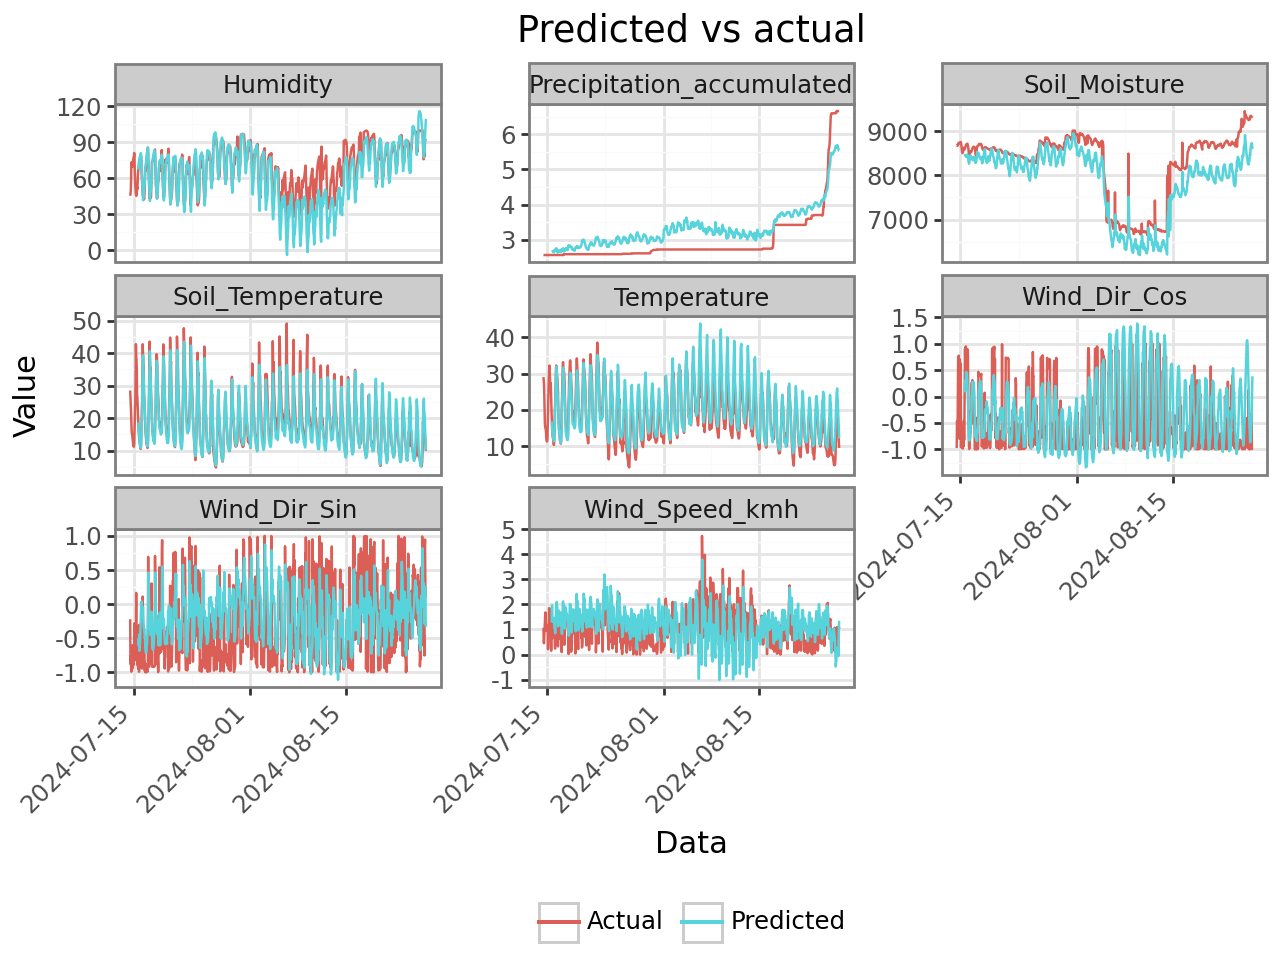

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [29]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

In [30]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

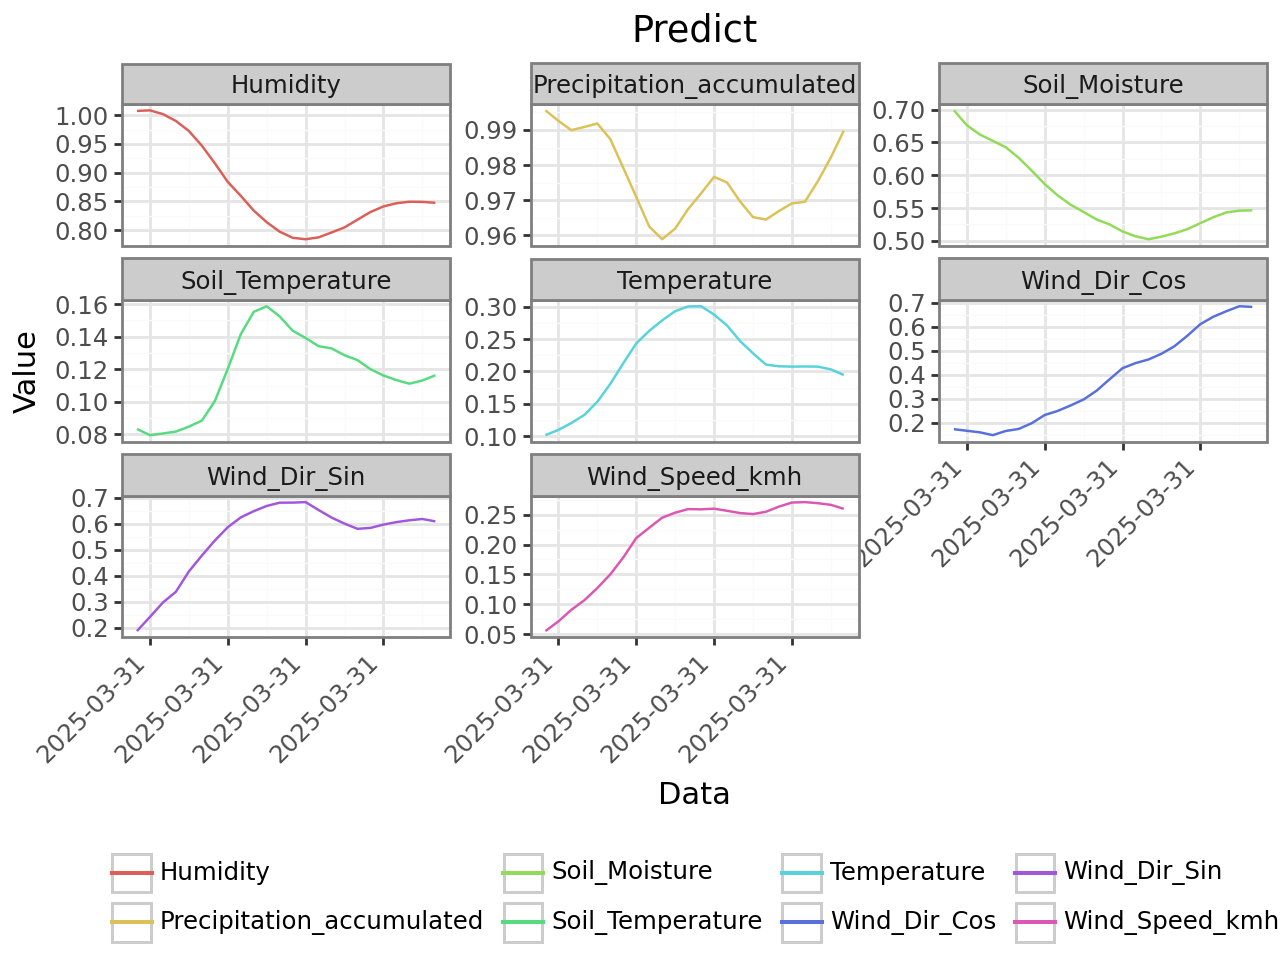

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_24.png


In [31]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Predict',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),

    )
)
plot.show()
plot.save('predict_24.png', width=12, height=10, dpi=300)

In [32]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)